<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>CatBoost</a></span></li></ul></li><li><span><a href="#Тестирование-лучшей-модели" data-toc-modified-id="Тестирование-лучшей-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Тестирование лучшей модели</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп» с BERT

## Подготовка

In [7]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [86]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 15.2 MB/s eta 0:00:00


In [8]:
import pandas as pd
import numpy as np
import re
from tqdm import notebook

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import(
    stopwords as nltk_stopwords,
    wordnet
)
from sklearn.feature_extraction.text import TfidfVectorizer

from catboost import CatBoostClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import(
    RandomizedSearchCV,
    train_test_split
)
from pymystem3 import Mystem
from sklearn.metrics import f1_score

import torch
import transformers as ppb

In [6]:
!gdown 1R67z81QTiGroLc-Gpoq2rAP5v7PFtLQH

/bin/bash: gdown: command not found


In [9]:
data = pd.read_csv('/datasets/toxic_comments.csv')

In [10]:
data.sample(5)

,Unnamed: 0,text,toxic
106628,106725,"Hello, and welcome to Wikipedia! We welcome an...",0
156789,156948,"Blocked for 3RR vio \n\nAs per above, you are ...",0
467,467,"Stay off my talk page, stalker. 12.39.2.83",0
81904,81980,GIVE ME LIBERTY OR GIVE ME DEATH! \n'LIVE F...,0
3705,3705,Please stop. If you continue to ignore our pol...,1


In [11]:
data.duplicated().sum()

0

In [12]:
data.isna().sum()

Unnamed: 0    0
text          0
toxic         0
dtype: int64

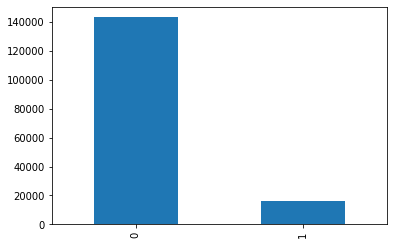

In [13]:
data['toxic'].value_counts().plot(kind='bar');

In [14]:
data['text'] = data['text'].str.lower()

In [10]:
data_text = []
pattern = r'[^а-яА-ЯёЁa-zA-Z0-9 ]'
for sentence in data['text']:
  cleared_text = re.sub(pattern, " ", sentence)
  data_text.append(" ". join(cleared_text.split()))

data["clear_text"] = data_text

In [16]:
data.head(5)

,Unnamed: 0,text,toxic,clear_text
0,0,explanation\nwhy the edits made under my usern...,0,explanation why the edits made under my userna...
1,1,d'aww! he matches this background colour i'm s...,0,d aww he matches this background colour i m se...
2,2,"hey man, i'm really not trying to edit war. it...",0,hey man i m really not trying to edit war it s...
3,3,"""\nmore\ni can't make any real suggestions on ...",0,more i can t make any real suggestions on impr...
4,4,"you, sir, are my hero. any chance you remember...",0,you sir are my hero any chance you remember wh...


### Вывод

Подготовил данные, провел общий обзор, установил дисбаланс классов, очистил текст

## Обучение

In [35]:
corpus = data.sample(n=2000,random_state=12345).reset_index(drop=True)

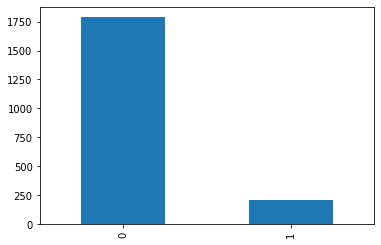

In [12]:
corpus['toxic'].value_counts().plot(kind='bar');

In [19]:
model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'unitary/toxic-bert')
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model_bert = model_class.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at unitary/toxic-bert were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [20]:
tokenized = corpus.clear_text.apply((lambda x: tokenizer.encode(x, add_special_tokens=True, truncation=True)))

In [21]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [22]:
padded.shape

(2000, 512)

In [23]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(2000, 512)

In [24]:
batch_size = 200

embeddings = []

for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
  batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)])
  attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
  with torch.no_grad():
    batch_embeddings = model_bert(batch, attention_mask=attention_mask_batch)
  embeddings.append(batch_embeddings[0][:,0,:].numpy())

  0%|          | 0/10 [00:00<?, ?it/s]

In [25]:
features = np.concatenate(embeddings)
target = corpus.toxic

In [26]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=.2, random_state=12345)

In [40]:
model_bert_logistic = LogisticRegression(random_state=12345, class_weight='balanced')

search_bert = RandomizedSearchCV(model_bert_logistic, {'max_iter': [100, 200]}, random_state=0, scoring='f1', n_iter=2, cv=2)
search_bert.fit(features_train, target_train)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

0.8979605372243409


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [41]:
search_bert.best_score_

0.8979605372243409

### CatBoost

In [13]:
L = WordNetLemmatizer()

In [14]:
def lemmatize(corpus):
  ''' функция выполняет токенизациию и лемматизацию массива текстов'''
  corpus_new = []
  for sentence in corpus:
    word_list = nltk.word_tokenize(sentence)
    corpus_new.append(' '.join([L.lemmatize(w) for w in word_list]))
  return corpus_new

In [15]:
def get_wordnet_pos(word):
    """функция возвращает словарь, где возвращается значение часть речи (pos_tag)"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
 
    return tag_dict.get(tag, wordnet.NOUN)

In [64]:

def get_word_text(corpus):
    return ' '.join([L.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(corpus) if not w in nltk_stopwords.words('english')])

In [42]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [38]:
corpus['clear_text'] = corpus['clear_text'].str.lower().apply(lambda sentence: re.sub("[^A-Za-z]", " ", sentence)).replace('  ', ' ')

In [66]:
corpus['lemm_text'] = corpus['clear_text'].apply(get_word_text)

In [68]:
X = corpus['lemm_text']
y = corpus['toxic']

In [69]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.2, random_state=12345)

In [70]:
stopwords = list(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stopwords)

tf_idf_train = count_tf_idf.fit_transform(X_train)
tf_idf_test = count_tf_idf.transform(X_test)

In [71]:
tf_idf_train.shape

(1600, 9635)

In [84]:
cb_model= CatBoostClassifier(auto_class_weights='Balanced',
                             #task_type="GPU",
                             eval_metric='F1',
                             learning_rate=0.01,
                             iterations=100,
                             verbose=50,
                             reg_lambda=0.8)
cb_model.fit(tf_idf_train, y_train)

0:	learn: 0.3546798	total: 92.8ms	remaining: 9.19s
50:	learn: 0.7245798	total: 3.54s	remaining: 3.4s
99:	learn: 0.8186966	total: 7.05s	remaining: 0us


## Тестирование лучшей модели

In [131]:
pred = search_bert.predict(features_test)
f1_score(target_test, pred)

0.9292929292929293

### Вывод

Обучил две модели, одна линейная модель - логистическая регрессия с нейронкой-кодировщиком BERT, вторя модель деревянной классификации. В первом случае получен результат на валиде 0.89 по метрике F1 - гармонической средней между полнотой и точностью. Вторая модель показала результат 0.88 примерно на валидационных данных. Обе модели обучались на одном корпусе данных из 2000 наблюдений.

## Выводы

Лучшей моделью оказалась логистическая регрессия с нейронкой. Тестирование показало результат - 0.93 примерно. Как показала практика модель на катбусте склонна к сильному переобучению, улучшило ситуацию коэфициент регулизации модели с ней переобучение удалось значительно снизить. В любом случае, результат с нейронкой лучший. Практически всегда определяет верно токсический комментарий. Из минусов стоит выделить очень долгое время подготовки (непосредственное кодирование) и обучения модели (если дообучать нейронку на верхних слоях, заморозив скрытые, рекомендуемо только для профильных наборов данных, например, сообщество рыболовов, так лексика будет у всех примерно одинакова, но это сложный вопрос)

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны